In [26]:
from __future__ import division
import cv2
import os
import time
import warnings
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import scipy.ndimage as ndi

from skimage import io
from skimage import transform
from skimage.transform import rotate 
from skimage import exposure
from scipy import ndimage
from scipy.signal import butter, lfilter

warnings.filterwarnings('ignore')

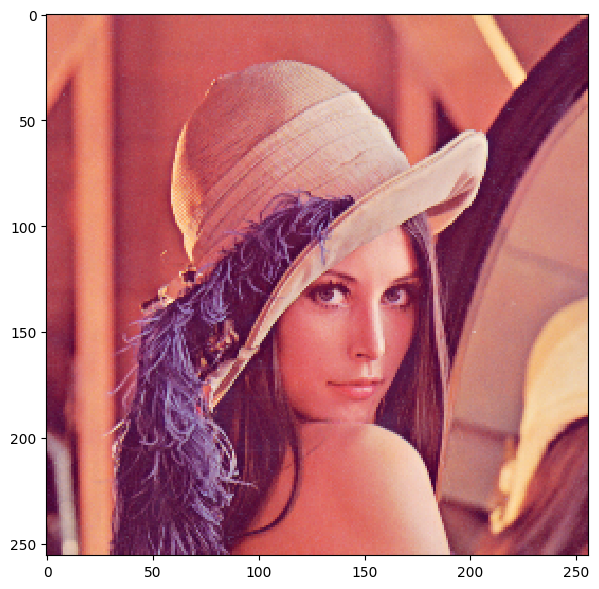

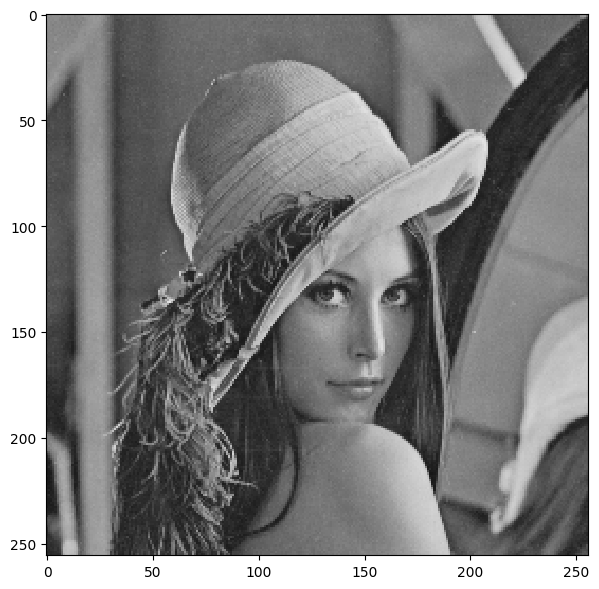

In [27]:
# show the RGB picture
imgRGB = io.imread('./source/Pictrue.png')
plt.figure(figsize=(15,6)) 
io.imshow(imgRGB)

# show the gray picture
imgGray = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(15,6)) 
io.imshow(imgGray, cmap = 'gray')

In [28]:
# This cell use FFT to compute Gaussian High-Pass Filter

timeStart = time.time()

# Make a Frequency Domain image
fftImg = np.fft.fftshift(np.fft.fft2(imgGray))
fftShiftImg = exposure.rescale_intensity(np.log(1+abs(fftImg)),out_range=(0.0, 1.0))

# Do fourier transform to this image
array = np.arange(-128,128)
x,y = np.meshgrid(array,array)
sigma = 25.0
cutRange = 1.0-np.exp(-(x**2+y**2)/sigma**2)
FourierImg = fftImg*cutRange

# Get this program runtime
timeEnd = time.time()
print("Runtime of Using FFT Algorithm in Gaussian High-Pass Filter :",timeEnd - timeStart,"s")

Runtime of Using FFT Algorithm in Gaussian High-Pass Filter : 0.004301548004150391 s


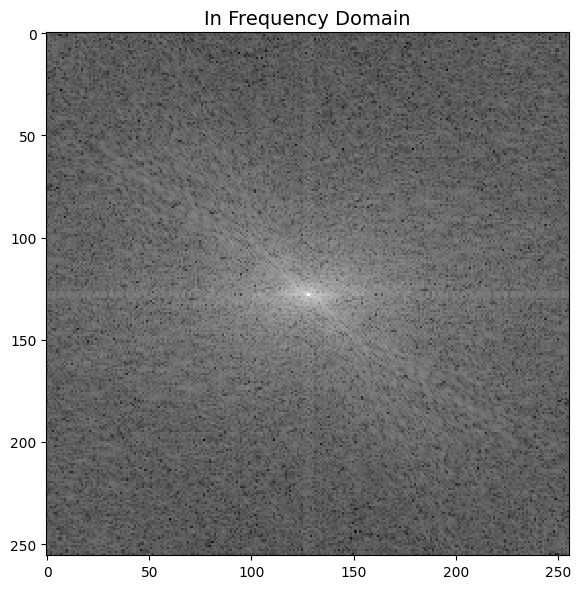

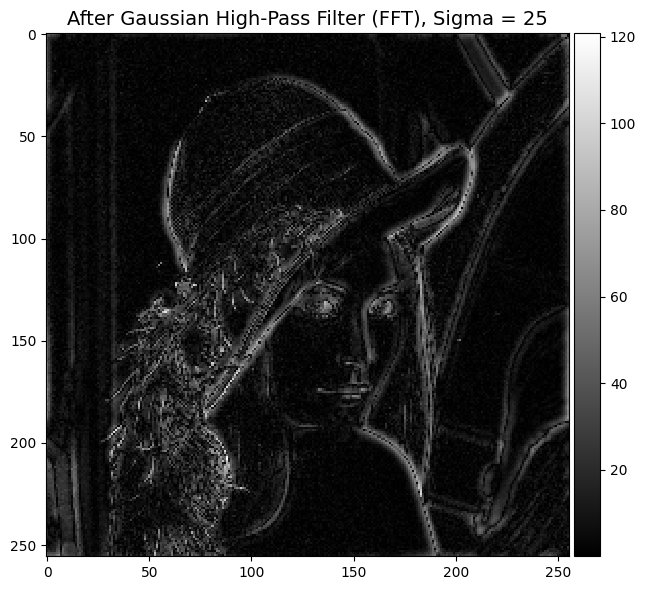

In [29]:
# Plot
plt.figure(figsize=(12,6)) 
plt.title("In Frequency Domain",fontsize = "14")
io.imshow(fftShiftImg)
plt.show()

plt.figure(figsize=(15,6)) 
plt.title("After Gaussian High-Pass Filter (FFT), Sigma = 25",fontsize = "14")
io.imshow(np.abs(np.fft.ifft2(FourierImg)), cmap='gray')
plt.show()

In [30]:
# This cell use FFT to compute Butterworth Filter

timeStart = time.time()

# Make a Frequency Domain image
fftImg = np.fft.fftshift(np.fft.fft2(imgGray))
fftShiftImg = exposure.rescale_intensity(np.log(1+abs(fftImg)),out_range=(0.0, 1.0))

# Do fourier transform to this image
array = np.arange(-128,128)
x,y = np.meshgrid(array,array)
D = 25.0
cutRange =  1-1.0/(1.0+((x**2+y**2)/D**2)**2)
FourierImg = fftImg*cutRange

# Get this program runtime
timeEnd = time.time()
print("Runtime of Using FFT Algorithm in ButterWorth High-Pass Filter :",timeEnd - timeStart,"s")

Runtime of Using FFT Algorithm in ButterWorth High-Pass Filter : 0.004462718963623047 s


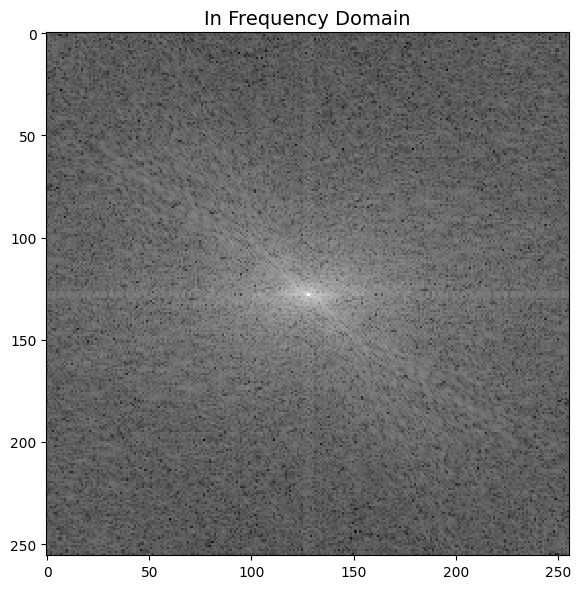

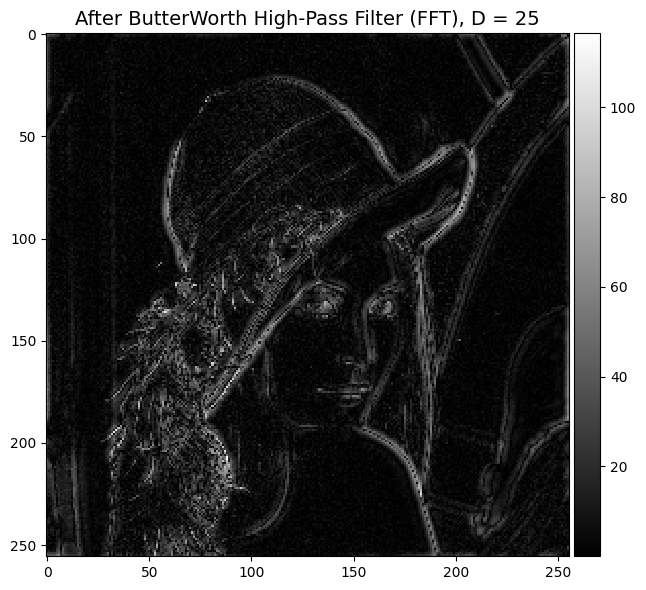

In [31]:
# Plot
plt.figure(figsize=(12,6)) 
plt.title("In Frequency Domain",fontsize = "14")
io.imshow(fftShiftImg)
plt.show()

plt.figure(figsize=(15,6)) 
plt.title("After ButterWorth High-Pass Filter (FFT), D = 25",fontsize = "14")
io.imshow(np.abs(np.fft.ifft2(FourierImg)), cmap='gray')
plt.show()